<a href="https://colab.research.google.com/github/cxbxmxcx/EvolutionaryDeepLearning/blob/main/EDL_12_1_GEPPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
.!pip install geppy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 160 kB 16.2 MB/s 
  Created wheel for geppy: filename=geppy-0.1.3-py3-none-any.whl size=34980 sha256=61fa3e5fd9ce2837151ecd719eb1b90fe3bec2b763a98ac9ae5abfc119384dfb
  Stored in directory: /root/.cache/pip/wheels/a7/48/3f/a58eb545ce7d05e9a5d25c041deb90ff65952f9943545bb912
Successfully built geppy


In [ ]:
import geppy as gep
from deap import creator, base, tools
import numpy as np
import random

# for reproduction
s = 0
random.seed(s)
np.random.seed(s)

In [ ]:
def f(x1):
    """Ground truth function"""
    return 6 * x1 + 22

In [ ]:
n_cases = 100
X1 = np.random.uniform(-10, 10, size=n_cases)   # random numbers in range [-10, 10)
Y = f(X1) + np.random.normal(size=n_cases)   

In [ ]:
def protected_div(x1, x2):
    if abs(x2) < 1e-6:
        return 1
    return x1 / x2

In [ ]:
import operator 

pset = gep.PrimitiveSet('Main', input_names=['x1'])
pset.add_function(operator.add, 2)
pset.add_function(operator.sub, 2)
pset.add_function(operator.mul, 2)
pset.add_function(protected_div, 2)
pset.add_ephemeral_terminal(name='enc', gen=lambda: random.randint(-10, 10)) # each ENC is a random integer within [-10, 10]

In [ ]:
from deap import creator, base, tools

creator.create("FitnessMin", base.Fitness, weights=(-1,))  # to minimize the objective (fitness)
creator.create("Individual", gep.Chromosome, fitness=creator.FitnessMin)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [ ]:
h = 7 # head length
n_genes = 2   # number of genes in a chromosome

In [ ]:
toolbox = gep.Toolbox()
toolbox.register('gene_gen', gep.Gene, pset=pset, head_length=h)
toolbox.register('individual', creator.Individual, gene_gen=toolbox.gene_gen, n_genes=n_genes, linker=operator.add)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# compile utility: which translates an individual into an executable function (Lambda)
toolbox.register('compile', gep.compile_, pset=pset)

In [ ]:
def evaluate(individual):
    """Evalute the fitness of an individual: MAE (mean absolute error)"""
    func = toolbox.compile(individual)
    Yp = np.array(list(map(func, X1)))
    return np.mean(np.abs(Y - Yp)),

toolbox.register('evaluate', evaluate)

In [ ]:
toolbox.register('select', tools.selTournament, tournsize=3)
# 1. general operators
toolbox.register('mut_uniform', gep.mutate_uniform, pset=pset, ind_pb=0.05, pb=1)
toolbox.register('mut_invert', gep.invert, pb=0.1)
toolbox.register('mut_is_transpose', gep.is_transpose, pb=0.1)
toolbox.register('mut_ris_transpose', gep.ris_transpose, pb=0.1)
toolbox.register('mut_gene_transpose', gep.gene_transpose, pb=0.1)
toolbox.register('cx_1p', gep.crossover_one_point, pb=0.4)
toolbox.register('cx_2p', gep.crossover_two_point, pb=0.2)
toolbox.register('cx_gene', gep.crossover_gene, pb=0.1)
toolbox.register('mut_ephemeral', gep.mutate_uniform_ephemeral, ind_pb='1p')  # 1p: expected one point mutation in an individual
toolbox.pbs['mut_ephemeral'] = 1  # we can also give the probability via the pbs property

In [ ]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [ ]:
# size of population and number of generations
n_pop = 100
n_gen = 100

pop = toolbox.population(n=n_pop)
hof = tools.HallOfFame(3)   # only record the best three individuals ever found in all generations

# start evolution
pop, log = gep.gep_simple(pop, toolbox, n_generations=n_gen, n_elites=1,
                          stats=stats, hall_of_fame=hof, verbose=True)

gen	nevals	avg   	std    	min   	max   
0  	100   	79.508	182.509	21.851	1618.7
1  	99    	35.3927	23.9588	20.3218	256.369
2  	99    	30.8422	7.34617	19.6921	75.5732
3  	99    	29.0236	8.98522	14.3142	96.4777
4  	99    	50.2893	188.118	6.72881	1898.59
5  	99    	30.629 	28.69  	6.72881	280.448
6  	99    	28.978 	33.8236	6.72881	351.204
7  	99    	28.9   	33.7767	6.72881	320.698
8  	99    	30.4022	30.6196	6.72881	283.503
9  	99    	26.2585	20.9953	6.19649	199.308
10 	99    	24.6556	25.7486	6.19649	263.798
11 	99    	26.3269	25.0928	6.19649	225.353
12 	99    	23.0573	10.8261	5.4406 	64.0733
13 	99    	28.8164	33.8838	2.23366	287.502
14 	99    	24.8104	13.9405	2.23366	95.0199
15 	99    	24.5155	36.0145	2.23366	365.314
16 	99    	23.5569	31.2204	2.23366	247.452
17 	99    	22.1811	21.0677	2.23366	200.087
18 	99    	20.111 	15.1699	2.23366	114.395
19 	99    	19.1431	11.1079	1.07121	62.1307
20 	99    	22.0577	39.6602	1.07121	396.978
21 	99    	17.9893	10.7395	1.07121	81.1317
22 	99    	21.732

In [ ]:
print(hof[0])

add(
	add(x1, add(x1, add(add(0, x1), add(4, -1)))),
	add(add(x1, add(6, 9)), add(x1, sub(x1, -4)))
)


In [ ]:
best_ind = hof[0]
symplified_best = gep.simplify(best_ind)
print('Symplified best individual: ')
print(symplified_best)

Symplified best individual: 
6*x1 + 22


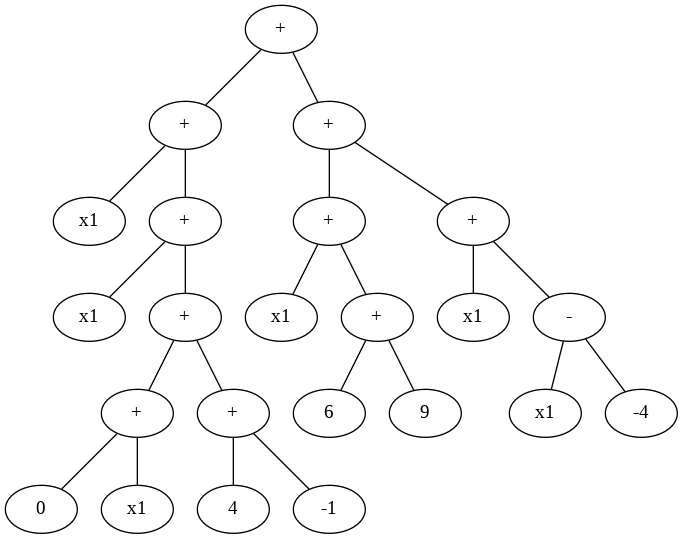

In [ ]:
# we want use symbol labels instead of words in the tree graph
rename_labels = {'add': '+', 'sub': '-', 'mul': '*', 'protected_div': '/'}  
gep.export_expression_tree(best_ind, rename_labels, 'data/numerical_expression_tree.png')

# show the above image here for convenience
from IPython.display import Image
Image(filename='data/numerical_expression_tree.png')